In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import FashionMNIST as FashionMNISTDataset
import quantus
import gc
import numpy as np
import torch
from captum.attr import *
import numpy as np
import torch
from torchvision import models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

import io
import os
import kornia
from scipy import interpolate
from typing import Callable, List, NamedTuple, Optional, Sequence, Tuple

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)


In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [4]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                      std=[x/255.0 for x in [63.0, 62.1, 66.7]])

transform_train = transforms.Compose([
            transforms.ToTensor(),
    
            ])
transform_test = transforms.Compose([
        transforms.ToTensor()
        ])

In [5]:
layers = 28 
widen_factor = 10 
droprate = 0 
nesterov = True 

In [6]:
train_loader = torch.utils.data.DataLoader(
        datasets.__dict__['CIFAR10']('../data', train=True, download=True,
                         transform=transform_train),
        batch_size=32, shuffle=True)

val_loader = torch.utils.data.DataLoader(
        datasets.__dict__['CIFAR10']('../data', train=False, transform=transform_test),
        batch_size=5, shuffle=False)

Files already downloaded and verified


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
#save images to folder; lots of and pick the best ones
normal_model = WideResNet(layers, 10 , widen_factor, dropRate=droprate)
normal_model.to(device)
normal_model.load_state_dict(torch.load('steps 7/Models/naturalCIFARWideResNet.pth'))
normal_model.eval()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [9]:
def create_blurred_image(full_img, pixel_mask):
  """ Creates a blurred (interpolated) image.
  Args:
    full_img: an original input image that should be used as the source for
      interpolation. The image should be represented by a numpy array with
      dimensions [H, W, C] or [H, W].
    pixel_mask: a binary mask, where 'True' values represent pixels that should
      be retrieved from the original image as the source for the interpolation
      and 'False' values represent pixels, which values should be found. The
      method always sets the corner pixels of the mask to True. The mask
      dimensions should be [H, W].
    method: the method to use for the interpolation. The 'linear' method is
      recommended. The alternative value is 'nearest'.
    Returns:
      A numpy array that encodes the blurred image with exactly the same
      dimensions and type as `full_img`.
  """

  data_type = full_img.dtype
  has_color_channel = full_img.ndim > 2
  if not has_color_channel:
    full_img = np.expand_dims(full_img, axis=2)
  channels = full_img.shape[2]

  # Always include corners.
  pixel_mask = pixel_mask.copy()
  height = pixel_mask.shape[0]
  width = pixel_mask.shape[1]
  pixel_mask[[0, 0, height - 1, height - 1], [0, width - 1, 0, width - 1]] = True

  mean_color = np.mean(full_img, axis=(0, 1))

  # If the mask consists of all pixels set to True then return the original
  # image.
  if np.all(pixel_mask):
    return full_img

  blurred_img = full_img * np.expand_dims(pixel_mask, axis=2).astype(
      np.float32)

  # Interpolate the unmasked values of the image pixels.
  for channel in range(channels):
    data_points = np.argwhere(pixel_mask > 0)
    data_values = full_img[:, :, channel][tuple(data_points.T)]
    unknown_points = np.argwhere(pixel_mask == 0)

    interpolated_values = interpolate.griddata(np.array(data_points), np.array(data_values), np.array(unknown_points),
                                              method = "linear", fill_value=mean_color[channel])
    blurred_img[:, :, channel][tuple(unknown_points.T)] = interpolated_values

  if not has_color_channel:
    blurred_img = blurred_img[:, :, 0]

  if issubclass(data_type.type, np.integer):
    blurred_img = np.round(blurred_img)

  return blurred_img.astype(data_type)

def generate_random_mask(image_height: int, image_width: int,
    fraction=0.01) -> np.ndarray:
  """Generates a random pixel mask.
    The result of this method can be used as the initial seed to generate
    a 'fully' blurred image with the help of the create_blurred_image(...)
    method.
    Args:
      image_height: the image height for which the mask should be generated.
      image_width: the image width for which the mask should be generated.
      fraction: the fraction of the mask pixels that should be set to true.
        The valid value range is [0.0, 1.0]. Set the value to 0.0 if no
        information from the original image should be used in the blurred image.
    Returns:
      The binary mask with the `fraction` of elements set to True.
  """
  mask = np.zeros(shape=[image_height, image_width], dtype=bool)
  size = mask.size
  indices = np.random.choice(size, replace=False, size=int(size * fraction))
  mask[np.unravel_index(indices, mask.shape)] = True
  return mask

def estimate_image_entropy(image: np.ndarray) -> float:
  """Estimates the amount of information in a given image.
    Args:
      image: an image, which entropy should be estimated. The dimensions of the
        array should be [H, W, C] or [H, W] of type uint8.
    Returns:
      The estimated amount of information in the image.
  """
  buffer = io.BytesIO()
  pil_image = Image.fromarray(image)
  pil_image.save(buffer, format='webp', lossless=True, quality=100)
  buffer.seek(0, os.SEEK_END)
  length = buffer.tell()
  buffer.close()
  return length

class ComputePicMetricError(Exception):
  """An error that can be raised by the compute_pic_metric(...) method.
  See the method description for more information.
  """
  pass

# returns softmax (SIC) or right/wrong (AIC)
def getPrediction(input, model, intendedClass, method, device):
    # calculate a prediction
    input = input.to(device)
    output = model(input)

    # if the intended class is unknown, find the class
    if intendedClass == -1:
        _, index = torch.max(output, 1)
        softmax = ((torch.nn.functional.softmax(output, dim = 1)[0])[index[0]]).detach().cpu().numpy()

        return softmax, index[0]
    # if the class index is known, determine the confidence or a right/wrong prediction 
    else:
      # SIC - return classification confidence of target class
      if method == 0:
        softmax = ((torch.nn.functional.softmax(output, dim = 1)[0])[intendedClass]).detach().cpu().numpy()

        return softmax, -1
      # AIC - return 1 or 0 based on correct classification or not
      elif method == 1:
        # find highest predicted class
        _, index = torch.max(output, 1)

        # determine if it matches the intended class
        if index[0] == intendedClass:
          return 1.0, -1
        else:
          return 0.0, -1


# computes SIC curve
class PicMetricResult(NamedTuple):
  """Holds results of compute_pic_metric(...) method."""
  # x-axis coordinates of PIC curve data points.
  curve_x: Sequence[float]
  # y-axis coordinates of PIC curve data points.
  curve_y: Sequence[float]
  # A sequence of intermediate blurred images used for PIC computation with
  # the fully blurred image in front and the original image at the end.
  blurred_images: Sequence[np.ndarray]
  # Model predictions for images in the `blurred_images` sequence.
  predictions: Sequence[float]
  # Saliency thresholds that were used to generate corresponding
  # `blurred_images`.
  thresholds: Sequence[float]
  # Area under the curve.
  auc: float

# computes SIC curve and AUC ONLY
class PicMetricResultBasic(NamedTuple):
  """Holds results of compute_pic_metric(...) method."""
  # x-axis coordinates of PIC curve data points.
  curve_x: Sequence[float]
  # y-axis coordinates of PIC curve data points.
  curve_y: Sequence[float]
  # Area under the curve.
  auc: float

def compute_pic_metric(img, saliency_map, random_mask, saliency_thresholds, method, model, device, normalization,
  min_pred_value: float = 0.8, keep_monotonous: bool = True, 
  num_data_points: int = 1000) -> PicMetricResult:
  """Computes Performance Information Curve for a single image.
    The method can be used to compute either Softmax Information Curve (SIC) or
    Accuracy Information Curve (AIC). The method computes the curve for a single
    image and saliency map. This method should be called repeatedly on different
    images and saliency maps.
    Args:
      img: an original image on which the curve should be computed. The numpy
        array should have dimensions [H, W, C] for a color image or [H, W]
        for a grayscale image. The array should be of type uint8.
      saliency_map: the saliency map for which the metric should be calculated.
        Usually, the saliency map should be calculated with respect to the
        same class label as the class label for which `pred_func` returns the
        prediction. However, the class labels may be different if you want
        to see how saliency for one class explains prediction of other class.
        Pixels with higher values are considered to be of higher importance.
        It is the responsibility of the caller to decide on the order of pixel
        importance, e.g. if the absolute values should be used instead of the
        signed ones, the caller should apply 'abs' function before calling this
        method. The shape of `saliency_map` is [H, W].
      random_mask: a random mask to use in order to create the initial
        completely blurred image.
      saliency_thresholds: the thresholds represent the fractions of the most
        important saliency pixels that will be used to reconstruct
        intermediate blurred images and pass them to the model for evaluation.
        The value of this argument should be the list of thresholds in
        ascending order. Example value: [0.005, 0.01, 0.02, 0.03, 0.04, 0.05,
        0.07, 0.10, 0.13, 0.21, 0.34, 0.5, 0.75].
      method: 0 or 1 passed by user to determine if the SIC or AIC test should be used
      model: the model used to make a prediction on an image tensor
      device: the device that the model runs on
      normalization: the pytorch tensor normalization transform for a given image and its dataset
      min_pred_value: used for filtering images. If the model prediction on the
        original image is lower than the value of this argument, the method
        raises ComputePicMetricError to indicate that the image should be
        skipped. This is done to filter out images that produce low prediction
        confidence.
      keep_monotonous: whether to keep the curve monotonically increasing.
        The value of this argument was set to 'True' in the original paper but
        setting it to 'False' is a viable alternative. 
      num_data_points: the number of PIC curve data points to return. The number
        excludes point 1.0 on the x-axis that is always appended to the end.
        E.g., value 1000 results in 1001 points evently distributed on the
        x-axis from 0.0 to 1.0 with 0.001 increment.
    Returns:
      The PIC curve data points and extra auxiliary information. See
      `PicMetricResult` for more information.
    Raises:
      ComputePicMetricError:
        The method raises the error in two cases. That happens in two cases:
        1. If the model prediction on the original image is not higher than the
           model prediction on the completely blurred image.
        2. If the entropy of the original image is not higher than the entropy
           of the completely blurred image.
        3. If the model prediction on the original image is lower than
           `min_pred_value`.
        If the error is raised, skip the image.
  """
  blurred_images = []
  predictions = []

  # This list will contain mapping of image entropy for a given saliency
  # threshold to model prediction.
  entropy_pred_tuples = []

  # Estimate entropy of the original image.
  original_img_entropy = estimate_image_entropy((img * 255).astype(np.uint8))

  # Estimate entropy of the completely blurred image.
  fully_blurred_img = create_blurred_image(img, random_mask)
  fully_blurred_img_entropy = estimate_image_entropy((fully_blurred_img * 255).astype(np.uint8))

  # Compute model prediction for the original image.
  input_img = torch.from_numpy(np.transpose(img, (2, 0, 1)))
  input_img = normalization(input_img)
  input_img = torch.unsqueeze(input_img, 0)

  # calculate the confidence percentage and the class of the original image
  original_img_pred, correctClassIndex = getPrediction(input_img, model, -1, method, device)

  # Compute model prediction for the completely blurred image.
  fully_blurred_pred_img = normalization(torch.from_numpy(np.transpose(fully_blurred_img, (2, 0, 1))))
  fully_blurred_pred_img = torch.unsqueeze(fully_blurred_pred_img, 0)
  # method 0 is always used here regardless of the function input since a softmax output for the specific class is needed
  fully_blurred_img_pred, _ = getPrediction(fully_blurred_pred_img, model, correctClassIndex, 0, device)

  blurred_images.append(fully_blurred_img)
  predictions.append(fully_blurred_img_pred)


  # Iterate through saliency thresholds and compute prediction of the model
  # for the corresponding blurred images with the saliency pixels revealed.
  max_normalized_pred = 0.0

  for threshold in saliency_thresholds:
    # blur the image
    quantile = np.quantile(saliency_map, 1 - threshold)

    pixel_mask = saliency_map >= quantile
    pixel_mask = np.logical_or(pixel_mask, random_mask)
    blurred_image = create_blurred_image(img, pixel_mask)


    entropy = estimate_image_entropy((blurred_image * 255).astype(np.uint8))

    # get the prediction value needed for SIC or AIC with the blurred image as input
    predInput = normalization(torch.from_numpy(np.transpose(blurred_image, (2, 0, 1))))
    predInput = torch.unsqueeze(predInput, 0)
    # method determines the return value of this function, see fuction description above
    # 0 is SIC, 1 is AIC
    pred, _ = getPrediction(predInput, model, correctClassIndex, method, device)

    # Normalize the values, so they lie in [0, 1] interval.
    normalized_entropy = (entropy - fully_blurred_img_entropy) / (original_img_entropy - fully_blurred_img_entropy)
    normalized_entropy = np.clip(normalized_entropy, 0.0, 1.0)
    normalized_pred = (pred - fully_blurred_img_pred) / (original_img_pred - fully_blurred_img_pred)
    normalized_pred = np.clip(normalized_pred, 0.0, 1.0)
    max_normalized_pred = max(max_normalized_pred, normalized_pred)

    # Make normalized_pred only grow if keep_monotonous is true.
    if keep_monotonous:
      entropy_pred_tuples.append((normalized_entropy, max_normalized_pred))
    else:
      entropy_pred_tuples.append((normalized_entropy, normalized_pred))

    blurred_images.append(blurred_image)
    predictions.append(pred)

  # Interpolate the PIC curve.
  entropy_pred_tuples.append((0.0, 0.0))
  entropy_pred_tuples.append((1.0, 1.0))

  entropy_data, pred_data = zip(*entropy_pred_tuples)

  interp_func = interpolate.interp1d(x=entropy_data, y=pred_data)

  curve_x = np.linspace(start=0.0, stop=1.0, num=num_data_points, endpoint=False)
  curve_y = np.asarray([interp_func(x) for x in curve_x])

  curve_x = np.append(curve_x, 1.0)
  curve_y = np.append(curve_y, 1.0)

  auc = np.trapz(curve_y, curve_x)

  blurred_images.append(img)
  predictions.append(original_img_pred)

  return PicMetricResultBasic(curve_x=curve_x, curve_y=curve_y, auc=auc)



class AggregateMetricResult(NamedTuple):
  """Holds results of aggregate_individual_pic_results(...) method."""
  # x-axis coordinates of aggregated PIC curve data points.
  curve_x: Sequence[float]
  # y-axis coordinates of aggregated PIC curve data points.
  curve_y: Sequence[float]
  # Area under the curve.
  auc: float


def visualizeImageGrayscale(image_3d, percentile=99):
  r"""Returns a 3D tensor as a grayscale 2D tensor.
  This method sums a 3D tensor across the absolute value of axis = 2, and then
  clips values at a given percentile.
  """
  image_2d = np.sum(np.abs(image_3d), axis=2)

  vmax = np.percentile(image_2d, percentile)
  vmin = np.min(image_2d)

  return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)
  
def show_image(im, title='', ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(12, 6))
  ax.axis('off')
  ax.imshow(im)
  ax.set_title(title)

def show_grayscale_image(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')

  plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
  plt.title(title)

In [10]:
# initialize PIC blur kernel
img_hw = 32
random_mask = generate_random_mask(img_hw, img_hw, .01)
saliency_thresholds = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.13, 0.21, 0.34, 0.5, 0.75]
keep_monotonous = True 


In [11]:
def compute_pic_score(x_batch, y_batch, given_model, method): 
    compute_pic_metrics_results = [] 
    for image, label in zip(x_batch, y_batch):
        blurred_images = [] 
        predictions = []
        entropy_pred_tuples = [] 

        #evaluate entropy of the original image; image has to be numpy of shape (H,W, C)
        image_ = image.permute(1, 2, 0)
        reshaped_np_image = image_.cpu().numpy()
        original_img_entropy = estimate_image_entropy((reshaped_np_image * 255).astype(np.uint8))

        #estimate entropy of the completely blurred image 
        fully_blurred_img = create_blurred_image(reshaped_np_image, random_mask)
        try:
            fully_blurred_img_entropy = estimate_image_entropy((fully_blurred_img * 255).astype(np.uint8))
        except:
            continue 

        # Compute model prediction for the original image; need confidence and index 
        input_img = torch.unsqueeze(image, 0)
        original_img_pred, correctClassIndex = getPrediction(input_img, given_model, -1, method, device)

        

        # Compute model prediction for the completely blurred image.
        fully_blurred_img2 = torch.from_numpy(fully_blurred_img) 
        fully_blurred_img3 = fully_blurred_img2.permute(2, 0, 1) 
        fully_blurred_pred_img = torch.unsqueeze(fully_blurred_img3, 0)

        # method 0 is always used here regardless of the function input since a softmax output for the specific class is needed
        fully_blurred_img_pred, _ = getPrediction(fully_blurred_pred_img, given_model, correctClassIndex, 0, device)


        blurred_images.append(fully_blurred_img)
        predictions.append(fully_blurred_img_pred)

        max_normalized_pred = 0.0

        #compute saliency 
        img = torch.unsqueeze(image, 0)
        lbl = torch.unsqueeze(label, 0)
        expl = Saliency(given_model).attribute(inputs=img, target=lbl).sum(axis=1).cpu().numpy()
        expl2 = np.abs(expl)
        saliency_map = expl2.squeeze()

        # Iterate through saliency thresholds and compute prediction of the model for the corresponding blurred images with the saliency pixels revealed.
        for threshold in saliency_thresholds:
            # blur the image
            quantile = np.quantile(saliency_map, 1 - threshold)
            pixel_mask = saliency_map >= quantile
            pixel_mask = np.logical_or(pixel_mask, random_mask)
            blurred_image = create_blurred_image(reshaped_np_image, pixel_mask)
            try:
                entropy = estimate_image_entropy((blurred_image * 255).astype(np.uint8))
            except:
                continue 

            # get the prediction value needed for SIC or AIC with the blurred image as input
            predInput = torch.from_numpy(blurred_image)
            predInput2 =  predInput.permute(2,0,1)
            predInput3 =  torch.unsqueeze(predInput2, 0)

            # method determines the return value of this function, see fuction description above # 0 is SIC, 1 is AIC
            pred, _ = getPrediction(predInput3, given_model, correctClassIndex, method, device)

            # Normalize the values, so they lie in [0, 1] interval.
            normalized_entropy = (entropy - fully_blurred_img_entropy) / (original_img_entropy - fully_blurred_img_entropy+0.000000001)
            normalized_entropy = np.clip(normalized_entropy, 0.0, 1.0)
            normalized_pred = (pred - fully_blurred_img_pred) / (original_img_pred - fully_blurred_img_pred)
            normalized_pred = np.clip(normalized_pred, 0.0, 1.0)
            max_normalized_pred = max(max_normalized_pred, normalized_pred)


            # Make normalized_pred only grow if keep_monotonous is true.
            if keep_monotonous:
                entropy_pred_tuples.append((normalized_entropy, max_normalized_pred))
            else:
                entropy_pred_tuples.append((normalized_entropy, normalized_pred))

            blurred_images.append(blurred_image)
            predictions.append(pred)

        # Interpolate the PIC curve.
        entropy_pred_tuples.append((0.0, 0.0))
        entropy_pred_tuples.append((1.0, 1.0))


        entropy_data, pred_data = zip(*entropy_pred_tuples)
        interp_func = interpolate.interp1d(x=entropy_data, y=pred_data)

        curve_x = np.linspace(start=0.0, stop=1.0, num=1000, endpoint=False)
        curve_y = np.asarray([interp_func(x) for x in curve_x])

        curve_x = np.append(curve_x, 1.0)
        curve_y = np.append(curve_y, 1.0)

        auc = np.trapz(curve_y, curve_x)

        blurred_images.append(img)
        predictions.append(original_img_pred)
        sic_score = PicMetricResultBasic(curve_x=curve_x, curve_y=curve_y, auc=auc)
        compute_pic_metrics_results.append(sic_score)
    return compute_pic_metrics_results

In [12]:
def aggregate_individual_pic_results(compute_pic_metrics_results, method):
    
    curve_ys = [r.curve_y for r in compute_pic_metrics_results]
    curve_ys = np.asarray(curve_ys)
    
    # Validate that x-axis points for all individual results are the same.
    curve_xs = [r.curve_x for r in compute_pic_metrics_results]
    curve_xs = np.asarray(curve_xs)
    _, counts = np.unique(curve_xs, axis=1, return_counts=True)
    if not np.all(counts == 1):
        raise ValueError('Individual results have different x-axis data points.')
        
    if method == 'mean':
        aggr_curve_y = np.mean(curve_ys, axis=0)
        
    elif method == 'median':
        aggr_curve_y = np.median(curve_ys, axis=0)
        
    auc = np.trapz(aggr_curve_y, curve_xs[0])
    
    return AggregateMetricResult(curve_x=curve_xs[0], curve_y=aggr_curve_y, auc=auc)

# AIC

In [13]:
pic=[]
for step, (x_batch, y_batch) in enumerate(val_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    outputs = normal_model(x_batch)
    predictions = torch.argmax(outputs, dim=1)
    correct_mask = predictions == y_batch
    x_batch = x_batch[correct_mask]
    y_batch = y_batch[correct_mask]
    pic_results = compute_pic_score(x_batch, y_batch, normal_model, 1)
    pic.extend(pic_results)
    if step == 400:
        break

pic_result_nat = aggregate_individual_pic_results(pic, 'mean')

/data/virtual environments/feature denoise/denoising_project/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [14]:
del normal_model

In [15]:
adversarial_model = WideResNet(layers, 10 , widen_factor, dropRate=droprate)
adversarial_model.to(device)
adversarial_model.load_state_dict(torch.load('steps 7/Models/Eps_B_advCIFARWideResNet.pth'))
adversarial_model.eval()

pic=[]
for step, (x_batch, y_batch) in enumerate(val_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    outputs = adversarial_model(x_batch)
    predictions = torch.argmax(outputs, dim=1)
    correct_mask = predictions == y_batch
    x_batch = x_batch[correct_mask]
    y_batch = y_batch[correct_mask]
    pic_results = compute_pic_score(x_batch, y_batch, adversarial_model, 1)
    pic.extend(pic_results)
    if step == 400:
        break

pic_result_adv = aggregate_individual_pic_results(pic, 'mean')

In [16]:
del adversarial_model

In [17]:
"""# using wide residual network"""

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)



class filter_denoising_block(torch.nn.Module):
    ''' Simple filters as denoising block'''
    def __init__(self, in_planes, ksize, filter_type):
        super(filter_denoising_block, self).__init__()
        self.in_planes = in_planes
        self.ksize = ksize
        self.filter_type = filter_type
        self.conv = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.filter_type == 'Median':
            x_denoised = kornia.filters.median_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Mean':
            x_denoised = kornia.filters.box_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Gaussian':
            x_denoised = kornia.filters.gaussian_blur2d(x, (self.ksize, self.ksize), (0.3 * ((x.shape[3] - 1) * 0.5 - 1) + 0.8, 0.3 * ((x.shape[2] - 1) * 0.5 - 1) + 0.8))
        new_x = x + self.conv(x_denoised)
        return new_x


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock

        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)

        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)

        # Denoising block
        self.denoise_block = filter_denoising_block(nChannels[1], ksize=3, filter_type='Mean')

        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)

        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)

        # Apply the denoising block
        out = self.denoise_block(out)

        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)


# In[11]:


path1= 'steps 7/Models/Layer_1_Mean_Eps_B_advCIFARWideResNet.pth'

In [18]:
# create model
mean_model = WideResNet(layers, 10 , widen_factor, dropRate=droprate)
mean_model = mean_model.cuda()
mean_model.load_state_dict(torch.load(path1))
mean_model.eval()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [19]:

pic=[]
for step, (x_batch, y_batch) in enumerate(val_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    outputs = mean_model(x_batch)
    predictions = torch.argmax(outputs, dim=1)
    correct_mask = predictions == y_batch
    x_batch = x_batch[correct_mask]
    y_batch = y_batch[correct_mask]
    pic_results = compute_pic_score(x_batch, y_batch, mean_model, 1)
    pic.extend(pic_results)
    if step == 400:
        break
pic_result_mean = aggregate_individual_pic_results(pic, 'mean')

In [20]:
del mean_model

In [21]:
"""# using wide residual network"""

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)


class filter_denoising_block(torch.nn.Module):
    ''' Simple filters as denoising block'''
    def __init__(self, in_planes, ksize, filter_type):
        super(filter_denoising_block, self).__init__()
        self.in_planes = in_planes
        self.ksize = ksize
        self.filter_type = filter_type
        self.conv = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.filter_type == 'Median':
            x_denoised = kornia.filters.median_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Mean':
            x_denoised = kornia.filters.box_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Gaussian':
            x_denoised = kornia.filters.gaussian_blur2d(x, (self.ksize, self.ksize), (0.3 * ((x.shape[3] - 1) * 0.5 - 1) + 0.8, 0.3 * ((x.shape[2] - 1) * 0.5 - 1) + 0.8))
        new_x = x + self.conv(x_denoised)
        return new_x


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock

        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)

        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)

        # Denoising block
        self.denoise_block = filter_denoising_block(nChannels[1], ksize=3, filter_type='Median')

        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)

        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)

        # Apply the denoising block
        out = self.denoise_block(out)

        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)


# In[11]:


path1= 'steps 7/Models/Layer_1_Median_Eps_B_advCIFARWideResNet.pth'

In [22]:
# create model
median_model = WideResNet(layers, 10 , widen_factor, dropRate=droprate)
median_model = median_model.cuda()
median_model.load_state_dict(torch.load(path1))
median_model.eval()

pic=[]
for step, (x_batch, y_batch) in enumerate(val_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    outputs = median_model(x_batch)
    predictions = torch.argmax(outputs, dim=1)
    correct_mask = predictions == y_batch
    x_batch = x_batch[correct_mask]
    y_batch = y_batch[correct_mask]
    pic_results = compute_pic_score(x_batch, y_batch, median_model, 1)
    pic.extend(pic_results)
    if step == 400:
        break
        
        
pic_result_median = aggregate_individual_pic_results(pic, 'mean')

In [23]:
del median_model

In [24]:

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)



class filter_denoising_block(torch.nn.Module):
    ''' Simple filters as denoising block'''
    def __init__(self, in_planes, ksize, filter_type):
        super(filter_denoising_block, self).__init__()
        self.in_planes = in_planes
        self.ksize = ksize
        self.filter_type = filter_type
        self.conv = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.filter_type == 'Median':
            x_denoised = kornia.filters.median_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Mean':
            x_denoised = kornia.filters.box_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Gaussian':
            x_denoised = kornia.filters.gaussian_blur2d(x, (self.ksize, self.ksize), (0.3 * ((x.shape[3] - 1) * 0.5 - 1) + 0.8, 0.3 * ((x.shape[2] - 1) * 0.5 - 1) + 0.8))
        new_x = x + self.conv(x_denoised)
        return new_x


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock

        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)

        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)

        # Denoising block
        self.denoise_block = filter_denoising_block(nChannels[1], ksize=3, filter_type='Gaussian')

        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)

        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)

        # Apply the denoising block
        out = self.denoise_block(out)

        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)


# In[13]:


path1= 'steps 7/Models/Layer_1_Gaussian_Eps_B_advCIFARWideResNet.pth'

In [25]:
gaussian_plus_adv = WideResNet(layers, 10 , widen_factor, dropRate=droprate)
gaussian_plus_adv = gaussian_plus_adv.cuda()
gaussian_plus_adv.load_state_dict(torch.load(path1))
gaussian_plus_adv.eval()


pic=[]
for step, (x_batch, y_batch) in enumerate(val_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    outputs = gaussian_plus_adv(x_batch)
    predictions = torch.argmax(outputs, dim=1)
    correct_mask = predictions == y_batch
    x_batch = x_batch[correct_mask]
    y_batch = y_batch[correct_mask]
    pic_results = compute_pic_score(x_batch, y_batch, gaussian_plus_adv, 1)
    pic.extend(pic_results)
    if step == 400:
        break

pic_result_gaussian = aggregate_individual_pic_results(pic, 'mean')

In [26]:
del gaussian_plus_adv 

In [27]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)



class filter_denoising_block(torch.nn.Module):
    ''' Simple filters as denoising block'''
    def __init__(self, in_planes, ksize, filter_type):
        super(filter_denoising_block, self).__init__()
        self.in_planes = in_planes
        self.ksize = ksize
        self.filter_type = filter_type
        self.conv = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.filter_type == 'Median':
            x_denoised = kornia.filters.median_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Mean':
            x_denoised = kornia.filters.box_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Gaussian':
            x_denoised = kornia.filters.gaussian_blur2d(x, (self.ksize, self.ksize), (0.3 * ((x.shape[3] - 1) * 0.5 - 1) + 0.8, 0.3 * ((x.shape[2] - 1) * 0.5 - 1) + 0.8))
        new_x = x + self.conv(x_denoised)
        return new_x


class non_local_denoising_block(torch.nn.Module):
    def __init__(self, in_channels, inter_channels = None, mode = 'embedded', bn_layer = True):

        """ in_channels: original channel size (1024 in the paper) #depends on the test dataset
            inter_channels: channel size inside the block if not specifed reduced to half (512 in the paper)
            mode: supports Gaussian, Embedded Gaussian, Dot Product, and Concatenation
            dimension: can be 1 (temporal), 2 (spatial), 3 (spatiotemporal)
            bn_layer: whether to add batch norm
            """

        super().__init__()
        self.in_channels = in_channels
        self.inter_channels = inter_channels
        self.mode = mode
        self.inter_channels = inter_channels

         # the channel size is reduced to half inside the block
        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1


        #dimension=2 for images
        conv_nd = nn.Conv2d
        max_pool_layer = nn.MaxPool2d(kernel_size=(2,2))
        bn = nn.BatchNorm2d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)

        # add BatchNorm layer after the last conv layer
        if bn_layer:
            self.W_z = nn.Sequential(
                    conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels, kernel_size=1),
                    bn(self.in_channels)
                )
            # from section 4.1 of the paper, initializing params of BN ensures that the initial state of non-local block is identity mapping
            nn.init.constant_(self.W_z[1].weight, 0)
            nn.init.constant_(self.W_z[1].bias, 0)
        else:
            self.W_z = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels, kernel_size=1)

            # from section 3.3 of the paper by initializing Wz to 0, this block can be inserted to any existing architecture
            nn.init.constant_(self.W_z.weight, 0)
            nn.init.constant_(self.W_z.bias, 0)


        # define theta and phi for all operations except gaussian
        if self.mode == "embedded" or self.mode == "dot" or self.mode == "concatenate":
            self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)
            self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)

        if self.mode == "concatenate":
            self.W_f = nn.Sequential(
                    nn.Conv2d(in_channels=self.inter_channels * 2, out_channels=1, kernel_size=1),
                    nn.ReLU()
                )

    def forward(self, x):
        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        if self.mode == "nonlocal_gaussian":
            theta_x = x.view(batch_size, self.in_channels, -1)
            phi_x = x.view(batch_size, self.in_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "embedded" or self.mode == "dot":
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "concatenate":
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1, 1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, 1, -1)

            h = theta_x.size(2)
            w = phi_x.size(3)
            theta_x = theta_x.repeat(1, 1, 1, w)
            phi_x = phi_x.repeat(1, 1, h, 1)

            concat = torch.cat([theta_x, phi_x], dim=1)
            f = self.W_f(concat)
            f = f.view(f.size(0), f.size(2), f.size(3))

        if self.mode == "nonlocal_gaussian" or self.mode == "embedded":
            f_div_C = F.softmax(f, dim=-1)
        elif self.mode == "dot" or self.mode == "concatenate":
            N = f.size(-1) # number of position in x
            f_div_C = f / N

        y = torch.matmul(f_div_C, g_x)

        # contiguous here just allocates contiguous chunk of memory
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])

        W_y = self.W_z(y)
        # residual connection
        z = W_y + x

        return z




class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock

        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)

        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)

        # Denoising block
        # self.denoise_block = filter_denoising_block(nChannels[1], ksize=3, filter_type='Median')
        self.non_local_denoise = non_local_denoising_block(in_channels=nChannels[1], inter_channels=nChannels[1] // 2, mode="embedded", bn_layer=True)

        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)

        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)

        # Apply the denoising block
        out = self.non_local_denoise(out)

        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)


# In[11]:


path1= 'steps 7/Models/Layer_1_Eps_B_Embedded_advCIFARWideResNet.pth'

In [28]:
embedded_plus_adv_model = WideResNet(layers, 10 , widen_factor, dropRate=droprate)
embedded_plus_adv_model = embedded_plus_adv_model.cuda()
embedded_plus_adv_model.load_state_dict(torch.load(path1))
embedded_plus_adv_model.eval()

pic=[]

for step, (x_batch, y_batch) in enumerate(val_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    outputs = embedded_plus_adv_model(x_batch)
    predictions = torch.argmax(outputs, dim=1)
    correct_mask = predictions == y_batch
    x_batch = x_batch[correct_mask]
    y_batch = y_batch[correct_mask]
    pic_results = compute_pic_score(x_batch, y_batch, embedded_plus_adv_model, 1)
    pic.extend(pic_results)
    if step == 400:
        break

pic_result_embedded = aggregate_individual_pic_results(pic, 'mean')

In [29]:
del embedded_plus_adv_model

In [30]:

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)



class filter_denoising_block(torch.nn.Module):
    ''' Simple filters as denoising block'''
    def __init__(self, in_planes, ksize, filter_type):
        super(filter_denoising_block, self).__init__()
        self.in_planes = in_planes
        self.ksize = ksize
        self.filter_type = filter_type
        self.conv = nn.Conv2d(in_channels=in_planes, out_channels=in_planes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.filter_type == 'Median':
            x_denoised = kornia.filters.median_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Mean':
            x_denoised = kornia.filters.box_blur(x, (self.ksize, self.ksize))
        elif self.filter_type == 'Gaussian':
            x_denoised = kornia.filters.gaussian_blur2d(x, (self.ksize, self.ksize), (0.3 * ((x.shape[3] - 1) * 0.5 - 1) + 0.8, 0.3 * ((x.shape[2] - 1) * 0.5 - 1) + 0.8))
        new_x = x + self.conv(x_denoised)
        return new_x


class non_local_denoising_block(torch.nn.Module):
    def __init__(self, in_channels, inter_channels = None, mode = 'nonlocal_gaussian', bn_layer = True):

        """ in_channels: original channel size (1024 in the paper) #depends on the test dataset
            inter_channels: channel size inside the block if not specifed reduced to half (512 in the paper)
            mode: supports Gaussian, Embedded Gaussian, Dot Product, and Concatenation
            dimension: can be 1 (temporal), 2 (spatial), 3 (spatiotemporal)
            bn_layer: whether to add batch norm
            """

        super().__init__()
        self.in_channels = in_channels
        self.inter_channels = inter_channels
        self.mode = mode
        self.inter_channels = inter_channels

         # the channel size is reduced to half inside the block
        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1


        #dimension=2 for images
        conv_nd = nn.Conv2d
        max_pool_layer = nn.MaxPool2d(kernel_size=(2,2))
        bn = nn.BatchNorm2d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)

        # add BatchNorm layer after the last conv layer
        if bn_layer:
            self.W_z = nn.Sequential(
                    conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels, kernel_size=1),
                    bn(self.in_channels)
                )
            # from section 4.1 of the paper, initializing params of BN ensures that the initial state of non-local block is identity mapping
            nn.init.constant_(self.W_z[1].weight, 0)
            nn.init.constant_(self.W_z[1].bias, 0)
        else:
            self.W_z = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels, kernel_size=1)

            # from section 3.3 of the paper by initializing Wz to 0, this block can be inserted to any existing architecture
            nn.init.constant_(self.W_z.weight, 0)
            nn.init.constant_(self.W_z.bias, 0)


        # define theta and phi for all operations except gaussian
        if self.mode == "embedded" or self.mode == "dot" or self.mode == "concatenate":
            self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)
            self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)

        if self.mode == "concatenate":
            self.W_f = nn.Sequential(
                    nn.Conv2d(in_channels=self.inter_channels * 2, out_channels=1, kernel_size=1),
                    nn.ReLU()
                )

    def forward(self, x):
        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        if self.mode == "nonlocal_gaussian":
            theta_x = x.view(batch_size, self.in_channels, -1)
            phi_x = x.view(batch_size, self.in_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "embedded" or self.mode == "dot":
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "concatenate":
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1, 1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, 1, -1)

            h = theta_x.size(2)
            w = phi_x.size(3)
            theta_x = theta_x.repeat(1, 1, 1, w)
            phi_x = phi_x.repeat(1, 1, h, 1)

            concat = torch.cat([theta_x, phi_x], dim=1)
            f = self.W_f(concat)
            f = f.view(f.size(0), f.size(2), f.size(3))

        if self.mode == "nonlocal_gaussian" or self.mode == "embedded":
            f_div_C = F.softmax(f, dim=-1)
        elif self.mode == "dot" or self.mode == "concatenate":
            N = f.size(-1) # number of position in x
            f_div_C = f / N

        y = torch.matmul(f_div_C, g_x)

        # contiguous here just allocates contiguous chunk of memory
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])

        W_y = self.W_z(y)
        # residual connection
        z = W_y + x

        return z




class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock

        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)

        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)

        # Denoising block
        # self.denoise_block = filter_denoising_block(nChannels[1], ksize=3, filter_type='Median')
        self.non_local_denoise = non_local_denoising_block(in_channels=nChannels[1], inter_channels=nChannels[1] // 2, mode="nonlocal_gaussian", bn_layer=True)

        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)

        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)

        # Apply the denoising block
        out = self.non_local_denoise(out)

        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)


# In[11]:


path1= 'steps 7/Models/Layer_1_nonlocal_gaussian_Eps_C_advCIFARWideResNet.pth'

In [31]:
# create model
gaussian_non_plus_adv_model = WideResNet(layers, 10 , widen_factor, dropRate=droprate)
gaussian_non_plus_adv_model = gaussian_non_plus_adv_model.cuda()
gaussian_non_plus_adv_model.load_state_dict(torch.load(path1))
gaussian_non_plus_adv_model.eval()


pic=[]
for step, (x_batch, y_batch) in enumerate(val_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    outputs = gaussian_non_plus_adv_model(x_batch)
    predictions = torch.argmax(outputs, dim=1)
    correct_mask = predictions == y_batch
    x_batch = x_batch[correct_mask]
    y_batch = y_batch[correct_mask]
    pic_results = compute_pic_score(x_batch, y_batch, gaussian_non_plus_adv_model, 1)
    pic.extend(pic_results)
    if step == 400:
        break
        
pic_result_ng = aggregate_individual_pic_results(pic, 'mean')

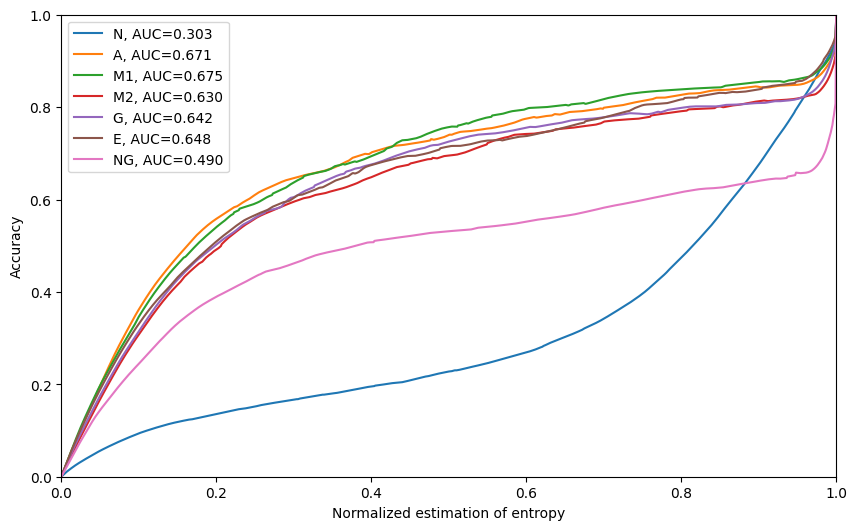

In [32]:
x1 = pic_result_nat.curve_x
y1 = pic_result_nat.curve_y
label_N = 'N'
auc1 = np.trapz(y1) / y1.size
label1 = f'{label_N}, AUC={auc1:.3f}'

x2 = pic_result_adv.curve_x
y2 = pic_result_adv.curve_y
label_A = 'A'
auc2 = np.trapz(y2) / y2.size
label2 = f'{label_A}, AUC={auc2:.3f}'

x3 = pic_result_mean.curve_x
y3 = pic_result_mean.curve_y
label_M1 = 'M1'
auc3 = np.trapz(y3) / y3.size
label3 = f'{label_M1}, AUC={auc3:.3f}'

x4 = pic_result_median.curve_x
y4 = pic_result_median.curve_y
label_M2 = 'M2'
auc4 = np.trapz(y4) / y4.size
label4 = f'{label_M2}, AUC={auc4:.3f}'

x5 = pic_result_gaussian.curve_x
y5 = pic_result_gaussian.curve_y
label_ = 'G'
auc5 = np.trapz(y5) / y5.size
label5 = f'{label_}, AUC={auc5:.3f}'

x6 = pic_result_embedded.curve_x
y6 = pic_result_embedded.curve_y
label_ = 'E'
auc6 = np.trapz(y6) / y6.size
label6 = f'{label_}, AUC={auc6:.3f}'

x7 = pic_result_ng.curve_x
y7 = pic_result_ng.curve_y
label_ = 'NG'
auc7 = np.trapz(y7) / y7.size
label7 = f'{label_}, AUC={auc7:.3f}'

plt.figure(figsize=(10, 6))

plt.plot(x1, y1, label=label1)
plt.plot(x2, y2, label=label2)
plt.plot(x3, y3, label=label3)
plt.plot(x4, y4, label=label4)
plt.plot(x5, y5, label=label5)
plt.plot(x6, y6, label=label6)
plt.plot(x7, y7, label=label7)

plt.ylabel('Accuracy')
plt.xlabel("Normalized estimation of entropy")
#plt.title("SIC")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

plt.savefig("CIFAR_PIC_AIC_ADV.pdf", format="pdf", bbox_inches="tight")

plt.show()